In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI SDK for Python: Vertex AI AutoML training hierarchical forecasting for batch prediction

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/automl/sdk_automl_forecasting_hierarchical_batch.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fofficial%2Fautoml%2Fsdk_automl_forecasting_hierarchical_batch.ipynb">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/automl/sdk_automl_forecasting_hierarchical_batch.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br>
      View on GitHub
    </a>
  </td>
  <td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/automl/sdk_automl_forecasting_hierarchical_batch.ipynb" target='_blank'>
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br>
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview


This tutorial demonstrates how to use the Vertex AI SDK for Python to create hierarchical forecasting models using  Google Cloud Vertex AI and do batch prediction. Specifically, you predict a fictional store's sales based on historical sales data.

Learn more about [Hierarchical forecasting for tabular data](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/hierarchical).

### Objective

In this tutorial, you create an AutoML hierarchical forecasting model and deploy it for batch prediction using the Vertex AI SDK for Python. You can alternatively create and deploy models using the `gcloud` command-line tool or batch using the Cloud Console.
The rationale for a hierarchical forecasting model is to minimize the error for a given group of sales data. The objective of this tutorial is to minimize the error for sale predictions at the "product" level.

This tutorial uses the following Google Cloud Vertex AI services:

- AutoML training
- Vertex AI datasets

The steps performed include:

- Create a Vertex AI TimeSeriesDataset resource.
- Train the model.
- View the model evaluation.
- Make a batch prediction.

### Dataset

The dataset used for this tutorial is a synthetically generated dataset of sales data for a fictional outdoor gear store. In this dataset, you predict a fictional store's sales based on historical sales data.

This dataset is synthesized to mimic sales pattern for a fictional outdoor gear store. There is a hierarchy between product_category, product_type and product as shown below:

- product_category: snow
    - product_type: skis
        - product: 
        
Additionally, this company has 3 store locations, each with their respective level of foot traffic.
- store: suburbs
- store: flagship
- store: downtown

Additional season effects are present in the data.

Link to data: gs://cloud-samples-data/vertex-ai/structured_data/forecasting/synthetic_sales_data.csv

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Get started

### Install Vertex AI SDK for Python and other required packages


In [ ]:
! pip3 install --upgrade google-cloud-aiplatform google-cloud-storage google-cloud-bigquery[pandas] seaborn scikit-learn

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK for Python

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [1]:
PROJECT_ID = "cool-skill-441812-b5"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [2]:
BUCKET_URI = f"gs://hierarchical-forecasting-{PROJECT_ID}-unique"  # @param {type:"string"}

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [13]:
! gsutil mb -l $LOCATION -p $PROJECT_ID $BUCKET_URI

Creating gs://hierarchical-forecasting-cool-skill-441812-b5-unique/...


### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [3]:
from google.cloud import aiplatform

# Initialize the Vertex AI SDK
aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

# Tutorial

Now you are ready to start creating your own AutoML time-series forecasting model.

### Create the Dataset

Use `TimeSeriesDataset.create()` to create a TimeSeriesDataset resource, which takes the following parameters:

- `display_name`: The human readable name for the dataset resource.
- `gcs_source`: A list of one or more dataset index files to import the data items into the dataset resource.
- `bq_source`: Alternatively, import data items from a BigQuery table into the dataset resource.

This operation may take several minutes.

### Download data


In [4]:
DATASET_URI = "gs://cloud-samples-data/vertex-ai/structured_data/forecasting/synthetic_sales_data.csv"

# Download the dataset
! gsutil cp {DATASET_URI} dataset.csv

Copying gs://cloud-samples-data/vertex-ai/structured_data/forecasting/synthetic_sales_data.csv...
/ [1 files][  1.6 MiB/  1.6 MiB]                                                
Operation completed over 1 objects/1.6 MiB.                                      


#### Split

In this use case, you are predicting the sales volume per product per store. 
Hence, you will need to create a new column called 'product_at_store', which is a concatenation of the 'product' and 'store' columns. This will be passed as the 'target_column' during training.

Lastly, split the dataset into a train and test dataset.
The train dataset is saved to CSV but the test dataset needs further treatment such as removing the target column.

In [5]:
import pandas as pd

DATASET_TRAIN_FILENAME = "sales_forecasting_train.csv"
DATASET_TEST_FILENAME = "sales_forecasting_test.csv"
DATASET_TRAIN_URI = f"{BUCKET_URI}/{DATASET_TRAIN_FILENAME}"

# Load dataset
df = pd.read_csv("dataset.csv")

df["date"] = df["date"].astype("datetime64[ns]")

# Add a target column
df["product_at_store"] = df["product"] + " (" + df["store"] + ")"
df = df[df['store'] == 'Flagship']

# Split dataset into train and test by taking the first 90% of data for training.
dates_unique = df["date"].unique()
date_cutoff = sorted(dates_unique)[round(len(dates_unique) * 9 / 10)]

# Save train dataset
df[df["date"] < date_cutoff].to_csv(DATASET_TRAIN_FILENAME, index=False)

# Create test dataset
df_test = df[df["date"] >= date_cutoff]

# Upload to GCS bucket
! gsutil cp {DATASET_TRAIN_FILENAME} {DATASET_TRAIN_URI}

Copying file://sales_forecasting_train.csv [Content-Type=text/csv]...
/ [1 files][609.7 KiB/609.7 KiB]                                                
Operation completed over 1 objects/609.7 KiB.                                    


#### Plot the dataset

Plot the 'sales' vs 'product_at_store' to get a sense of the dataset.

Note the peak in 'Snow' products during winter months and a peak in 'Water' products in the summer months.

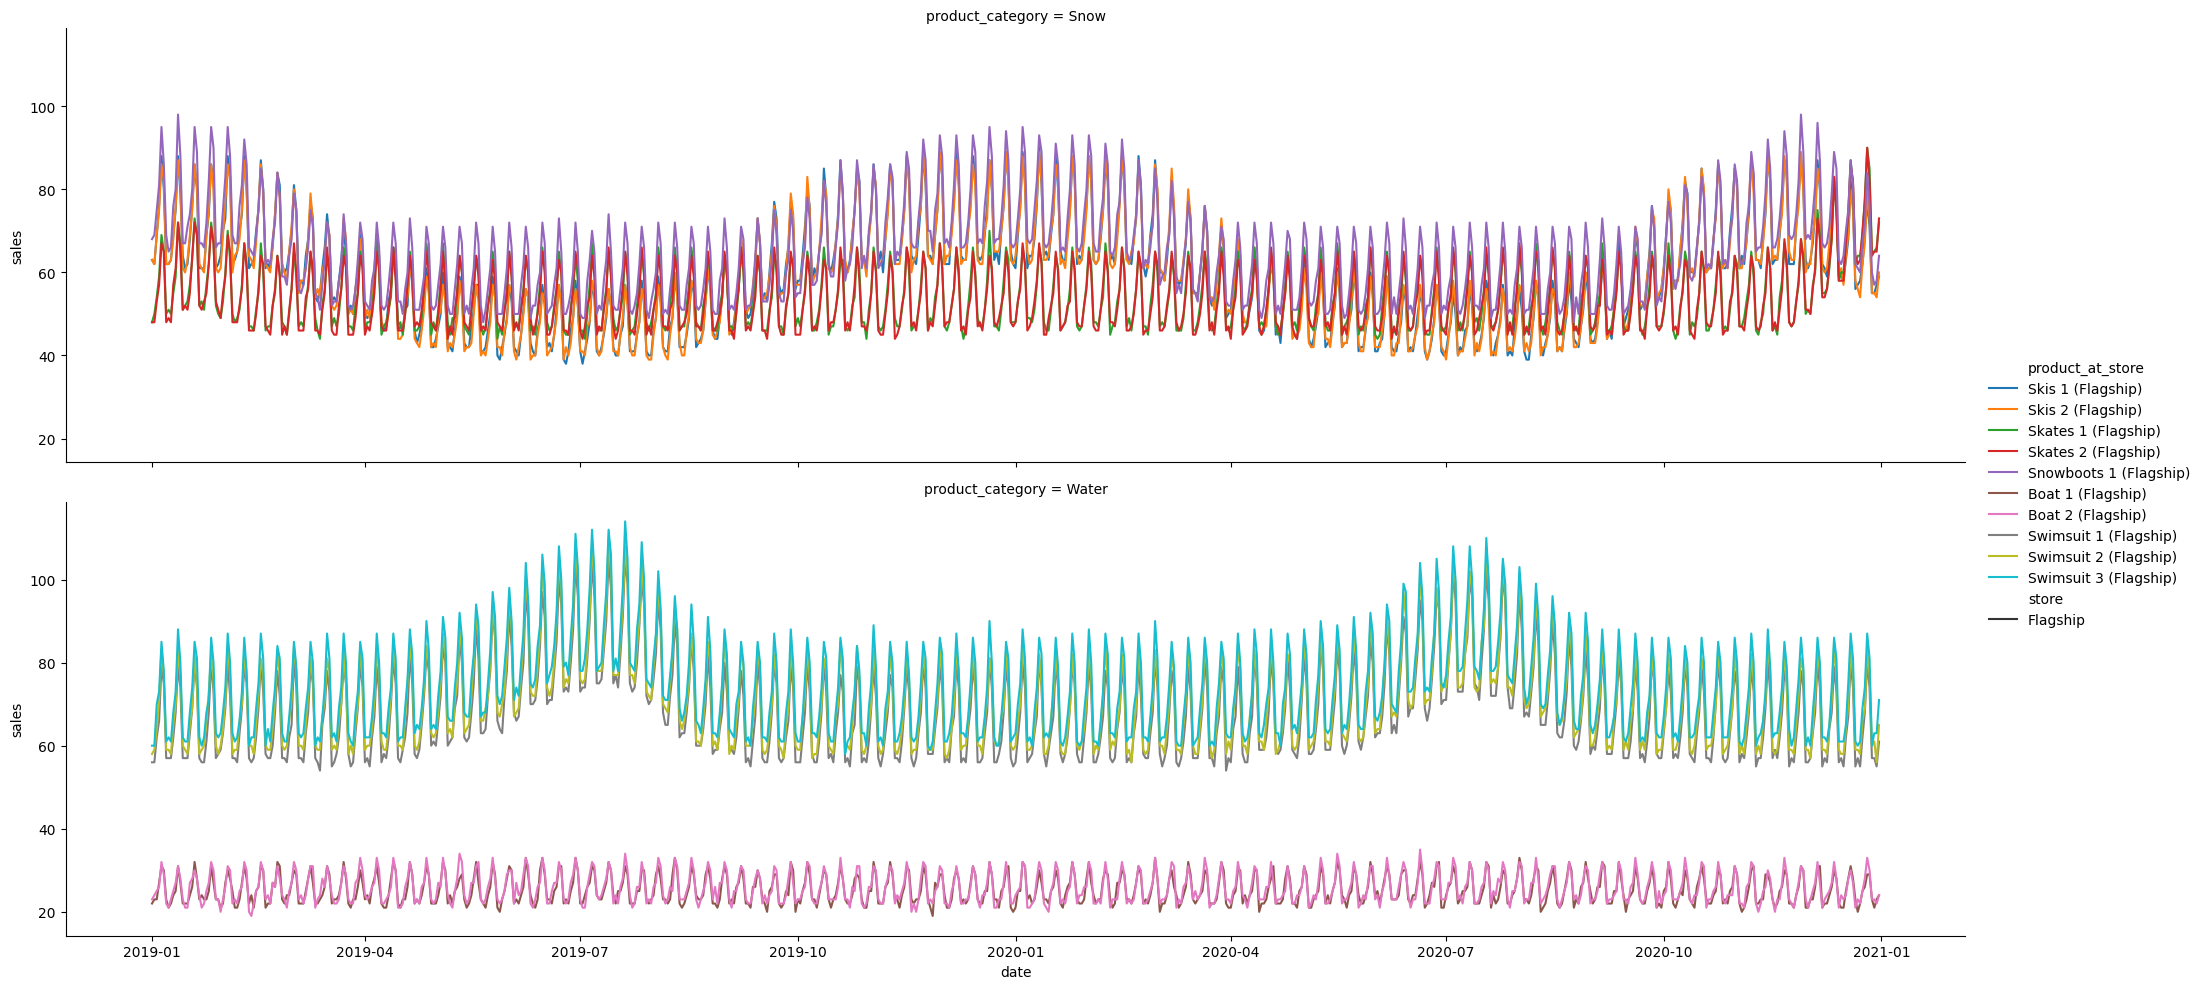

In [6]:
import seaborn as sns

sns.relplot(
    data=df,
    x="date",
    y="sales",
    hue="product_at_store",
    row="product_category",
    aspect=4,
    kind="line",
    style="store",
)

In [7]:
dataset_time_series = aiplatform.TimeSeriesDataset.create(gcs_source=DATASET_TRAIN_URI)

print(dataset_time_series.resource_name)

Creating TimeSeriesDataset
Create TimeSeriesDataset backing LRO: projects/247507300617/locations/us-central1/datasets/353176878736998400/operations/137206853439324160
TimeSeriesDataset created. Resource name: projects/247507300617/locations/us-central1/datasets/353176878736998400
To use this TimeSeriesDataset in another session:
ds = aiplatform.TimeSeriesDataset('projects/247507300617/locations/us-central1/datasets/353176878736998400')
projects/247507300617/locations/us-central1/datasets/353176878736998400


### Create and run training pipeline

To train an AutoML model, create and run a training pipeline.

#### Create training job

Create an AutoML training pipeline using the `AutoMLForecastingTrainingJob` class, with the following parameters:

- `display_name`: The human readable name for the TrainingJob resource.
- `column_transformations`: (Optional): Transformations to apply to the input columns
- `optimization_objective`: The optimization objective (minimize or maximize).
  - regression:
    - `minimize-rmse`
    - `minimize-mae`
    - `minimize-rmsle`

In [8]:
training_job = aiplatform.AutoMLForecastingTrainingJob(
    display_name="autoML_sales_forecasting",
    optimization_objective="minimize-rmse",
    column_specs={
        "date": "timestamp",
        "sales": "numeric",
        #"product_type": "categorical",
        #"product_category": "categorical",
        "product": "categorical",
        "store": "categorical",
    },
)

### Set context and horizon

You need to the context window and forecast horizon when you train a forecasting model.
- The context window sets how far back the model looks during training (and for forecasts). In other words, for each training datapoint, the context window determines how far back the model looks for predictive patterns.
- The forecast horizon determines how far into the future the model forecasts the target value for each row of prediction data.

See more here: [Considerations for setting the context window and forecast horizon](https://cloud.google.com/vertex-ai/docs/datasets/bp-tabular?hl=en#context-window)

In [9]:
# Each row represents a day, so we set context and time horizon to 30 to represent 30 days.

CONTEXT_WINDOW = 10
TIME_HORIZON = 3

#### Run the training pipeline

Run the training job by invoking the `run` method with the following parameters:

- `dataset`: The dataset resource to train the model.
- `model_display_name`: The human readable name for the trained model.
- `training_fraction_split`: The percentage of the dataset to use for training.
- `test_fraction_split`: The percentage of the dataset to use for test (holdout data).
- `validation_fraction_split`: The percentage of the dataset to use for validation.
- `target_column`: The name of the column to train as the label.
- `budget_milli_node_hours`: (optional) Maximum training time specified in unit of millihours (1000 = hour).

The `run` method when completed returns the model resource.

#### Setting the hierarchical parameters
We want to group by 'product' to minimize the error at this level.
Hence, you should set the group parameter to "product".

Setting the `group_total_weight` to a non-zero weight means that you want to weigh the group aggregated loss relative to the individual loss. Set that to 10 for demonstration purposes.

See more info at https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/hierarchical

In [ ]:
time_column = "date"
time_series_identifier_column = "product_at_store"
target_column = "sales"

model = training_job.run(
    dataset=dataset_time_series,
    target_column=target_column,
    time_column=time_column,
    time_series_identifier_column=time_series_identifier_column,
    available_at_forecast_columns=[time_column],
    unavailable_at_forecast_columns=[target_column],
    time_series_attribute_columns=[
        #"product_type",
        #"product_category",
        "store",
        "product",
    ],
    forecast_horizon=TIME_HORIZON,
    data_granularity_unit="day",
    data_granularity_count=1,
    model_display_name="autoML_sales_forecasting_model",
    weight_column=None,
    #hierarchy_group_columns=["product"],
    #hierarchy_group_total_weight=10,
)

No dataset split provided. The service will use a default split.
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/7014679366810468352?project=247507300617
AutoMLForecastingTrainingJob projects/247507300617/locations/us-central1/trainingPipelines/7014679366810468352 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/247507300617/locations/us-central1/trainingPipelines/7014679366810468352 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/247507300617/locations/us-central1/trainingPipelines/7014679366810468352 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/247507300617/locations/us-central1/trainingPipelines/7014679366810468352 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLForecastingTrainingJob projects/247507300617/locations/us-central1/trainingPipelines/7014679366810468352 current state:
PipelineState.PIPELINE_ST

## Review model evaluation scores
After your model has finished training, you can review its evaluation scores.

In [11]:
# Get evaluations
model_evaluations = model.list_model_evaluations()

model_evaluation = list(model_evaluations)[0]
print(model_evaluation)

resource name: projects/247507300617/locations/us-central1/models/274074163944095744@1/evaluations/5809132768606252029


## Send a batch prediction request

Now you can make a batch prediction.

### Prepare the test dataset

For forecasting, the test dataset needs to have context window rows which have information on the target column and subsequent time horizon rows where the target column is unknown. Construct these two sections and combine them into a single CSV file.

In [12]:
import numpy as np

# Store start and end dates for context and horizon
date_context_window_start = date_cutoff
date_context_window_end = date_cutoff + np.timedelta64(CONTEXT_WINDOW, "D")
time_horizon_end = date_context_window_end + np.timedelta64(TIME_HORIZON, "D")

# Extract dataframes for context and horizon
df_test_context = df_test[
    (df_test["date"] >= date_context_window_start)
    & (df_test["date"] < date_context_window_end)
]
df_test_horizon = df_test[
    (df_test["date"] >= date_context_window_end) & (df_test["date"] < time_horizon_end)
].copy()

# Save a copy for validation of predictions
df_test_horizon_actual = df_test_horizon.copy()

# Remove sales for horizon (i.e. future dates)
df_test_horizon["sales"] = ""

# Write test data to CSV
df_test = pd.concat([df_test_context, df_test_horizon])
df_test.to_csv(DATASET_TEST_FILENAME, index=False)

# Save test dataset
DATASET_TEST_URI = f"{BUCKET_URI}/{DATASET_TEST_FILENAME}"

# Upload to GCS bucket
! gsutil cp {DATASET_TEST_FILENAME} {DATASET_TEST_URI}

Copying file://sales_forecasting_test.csv [Content-Type=text/csv]...
/ [1 files][ 12.1 KiB/ 12.1 KiB]                                                
Operation completed over 1 objects/12.1 KiB.                                     


### Examine the context dataframe

Note that the sales column is filled.

In [13]:
df_test_context.head()

,date_index,product_index,store_index,date,day_of_week,temperature,product,product_type,product_category,store,sales,product_at_store
19740,658,0,0,2020-10-20,1,7.164706,Skis 1,Skis,Snow,Flagship,61.0,Skis 1 (Flagship)
19743,658,1,0,2020-10-20,1,7.164706,Skis 2,Skis,Snow,Flagship,61.0,Skis 2 (Flagship)
19746,658,2,0,2020-10-20,1,7.164706,Skates 1,Skates,Snow,Flagship,46.0,Skates 1 (Flagship)
19749,658,3,0,2020-10-20,1,7.164706,Skates 2,Skates,Snow,Flagship,47.0,Skates 2 (Flagship)
19752,658,4,0,2020-10-20,1,7.164706,Snowboots 1,Snowboots,Snow,Flagship,62.0,Snowboots 1 (Flagship)


### Examine the time horizon dataframe

Note that the sales column is empty.

In [14]:
df_test_horizon.head()

,date_index,product_index,store_index,date,day_of_week,temperature,product,product_type,product_category,store,sales,product_at_store
20040,668,0,0,2020-10-30,4,6.803922,Skis 1,Skis,Snow,Flagship,,Skis 1 (Flagship)
20043,668,1,0,2020-10-30,4,6.803922,Skis 2,Skis,Snow,Flagship,,Skis 2 (Flagship)
20046,668,2,0,2020-10-30,4,6.803922,Skates 1,Skates,Snow,Flagship,,Skates 1 (Flagship)
20049,668,3,0,2020-10-30,4,6.803922,Skates 2,Skates,Snow,Flagship,,Skates 2 (Flagship)
20052,668,4,0,2020-10-30,4,6.803922,Snowboots 1,Snowboots,Snow,Flagship,,Snowboots 1 (Flagship)


### Create a results dataset

Create a BigQuery dataset to store the prediction results.

In [15]:
from google.cloud import bigquery

# Create client in default region
bigquery_client = bigquery.Client(
    project=PROJECT_ID,
    credentials=aiplatform.initializer.global_config.credentials,
)

In [16]:
def create_bigquery_dataset(name: str, region: str):
    batch_predict_bq_output_uri_prefix = "bq://{}.{}".format(PROJECT_ID, name)

    bq_dataset = bigquery.Dataset("{}.{}".format(PROJECT_ID, name))

    dataset_region = region
    bq_dataset.location = dataset_region
    bq_dataset = bigquery_client.create_dataset(bq_dataset)
    print(
        "Created bigquery dataset {} in {}".format(
            batch_predict_bq_output_uri_prefix, dataset_region
        )
    )

    return batch_predict_bq_output_uri_prefix

In [ ]:
batch_predict_bq_output_uri_prefix = create_bigquery_dataset(
    name="hierarchical_forecasting_unique", region=LOCATION
)

### Make the batch prediction request

You can make a batch prediction by invoking the `batch_predict()` method, with the following parameters:

- `job_display_name`: The human readable name for the batch prediction job.
- `gcs_source`: A list of one or more batch request input files.
- `bigquery_destination_prefix`: The BigQuery destiantion location for storing the batch prediction results.
- `instances_format`: The format for the input instances, either 'bigquery', 'csv' or 'jsonl'. Defaults to 'jsonl'.
- `predictions_format`: The format for the output predictions, either 'csv', 'jsonl' or 'bigquery'. Defaults to 'jsonl'.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.
- `sync`: If set to True, the call will block while waiting for the asynchronous batch job to complete.

In [ ]:
# code to make batch prediction using existing model


In [15]:
batch_predict_bq_output_uri_prefix = "bq://cool-skill-441812-b5.hierarchical_forecasting_unique"

In [ ]:
batch_prediction_job = model.batch_predict(
    job_display_name="hierarchical_forecasting_unique",
    gcs_source=DATASET_TEST_URI,
    instances_format="csv",
    bigquery_destination_prefix=batch_predict_bq_output_uri_prefix,
    predictions_format="bigquery",
    generate_explanation=True,
    sync=True,
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/247507300617/locations/us-central1/batchPredictionJobs/931864382604836864
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/247507300617/locations/us-central1/batchPredictionJobs/931864382604836864')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/931864382604836864?project=247507300617
BatchPredictionJob projects/247507300617/locations/us-central1/batchPredictionJobs/931864382604836864 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/247507300617/locations/us-central1/batchPredictionJobs/931864382604836864 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/247507300617/locations/us-central1/batchPredictionJobs/931864382604836864 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/247507300617/locations/us-central1/batchPredictionJobs/931864

###  View the batch prediction results

Use the BigQuery Python client to query the destination table and return results as a Pandas dataframe.

In [17]:
# View the results as a dataframe
df_output = batch_prediction_job.iter_outputs(bq_max_results=1000).to_dataframe()

# Convert the dates to the datetime64 datatype
df_output["date"] = df_output["date"].astype("datetime64[ns]")

# Extract the predicted sales and convert to floats
df_output["predicted_sales"] = (
    df_output["predicted_sales"].apply(lambda x: x["value"]).astype(float)
)

df_output.head()

,date,explanation,predicted_on_date,predicted_sales,product,product_at_store,sales,store
0,2020-10-30,{'attributions': [{'featureAttributions': {'da...,2020-10-30,67.972221,Swimsuit 1,Swimsuit 1 (Flagship),None,Flagship
1,2020-10-30,{'attributions': [{'featureAttributions': {'da...,2020-10-30,73.595886,Skis 2,Skis 2 (Flagship),None,Flagship
2,2020-10-30,{'attributions': [{'featureAttributions': {'da...,2020-10-30,55.366199,Skates 1,Skates 1 (Flagship),None,Flagship
3,2020-10-30,{'attributions': [{'featureAttributions': {'da...,2020-10-30,26.608519,Boat 2,Boat 2 (Flagship),None,Flagship
4,2020-10-30,{'attributions': [{'featureAttributions': {'da...,2020-10-30,72.566002,Swimsuit 3,Swimsuit 3 (Flagship),None,Flagship


### Compare predictions vs ground truth

Plot the predicted sales vs the ground truth

/var/tmp/ipykernel_3422/3087542650.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_prediction_comparison = pd.concat([df_output, df_test_horizon_actual])
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 2400x1200 with 0 Axes>

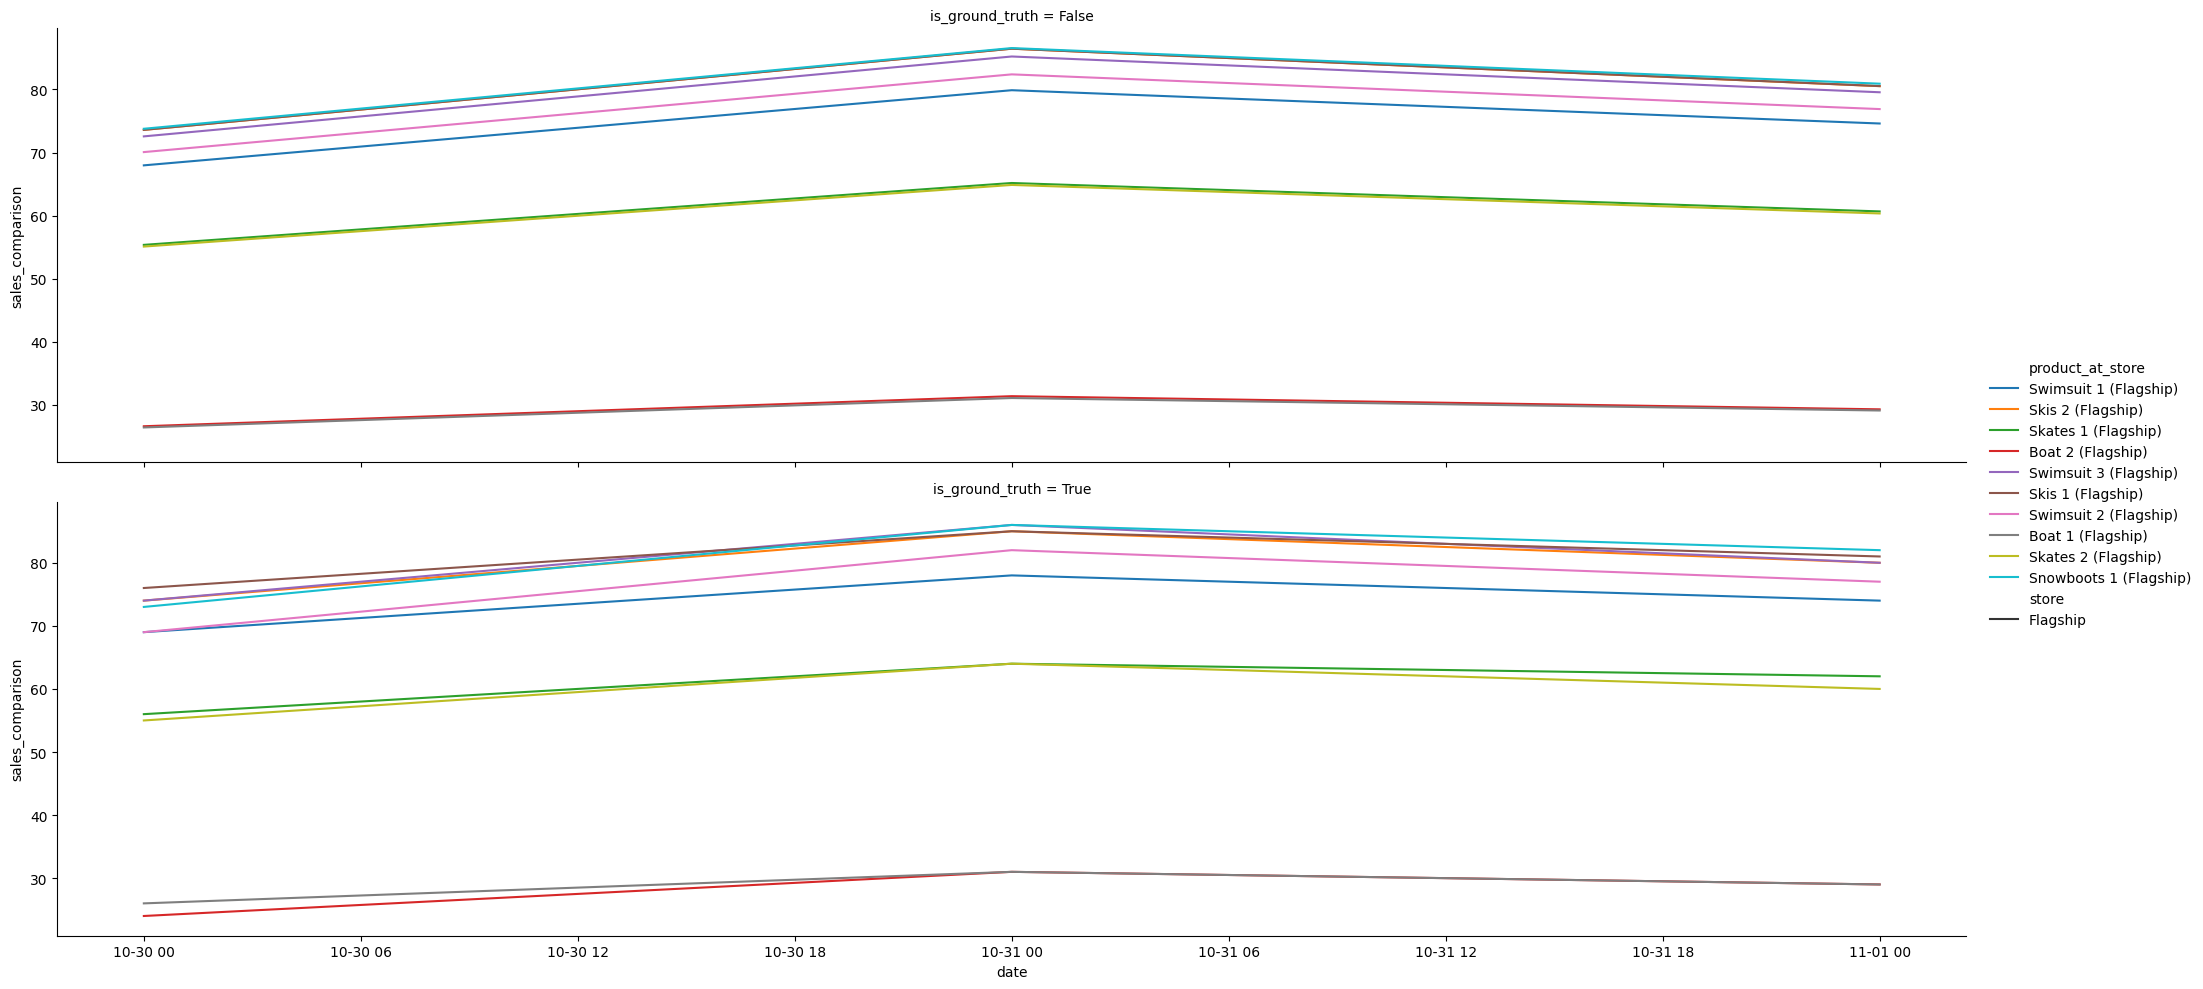

In [18]:
import matplotlib.pyplot as plt

# Create a shared dataframe to plot predictions vs ground truth
df_output["sales_comparison"] = df_output["predicted_sales"]
df_output["is_ground_truth"] = False
df_test_horizon_actual["sales_comparison"] = df_test_horizon_actual["sales"]
df_test_horizon_actual["is_ground_truth"] = True
df_prediction_comparison = pd.concat([df_output, df_test_horizon_actual])

# Plot sales
fig = plt.gcf()
fig.set_size_inches(24, 12)

sns.relplot(
    data=df_prediction_comparison,
    x="date",
    y="sales_comparison",
    hue="product_at_store",
    style="store",
    row="is_ground_truth",
    height=5,
    aspect=4,
    kind="line",
    ci=None,
)

# Clean up
To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Model
- AutoML Training Job
- Batch Job
- Cloud Storage Bucket

In [ ]:
from google.cloud import bigquery

# Create client in default region
bq_client = bigquery.Client(
    project=PROJECT_ID,
    credentials=aiplatform.initializer.global_config.credentials,
)

In [ ]:
# Delete BigQuery datasets
bq_client.delete_dataset(
    f"{PROJECT_ID}.hierarchical_forecasting_unique",
    delete_contents=True,
    not_found_ok=True,
)

In [ ]:
# Delete Vertex AI resources
dataset_time_series.delete()
model.delete()
training_job.delete()
batch_prediction_job.delete()